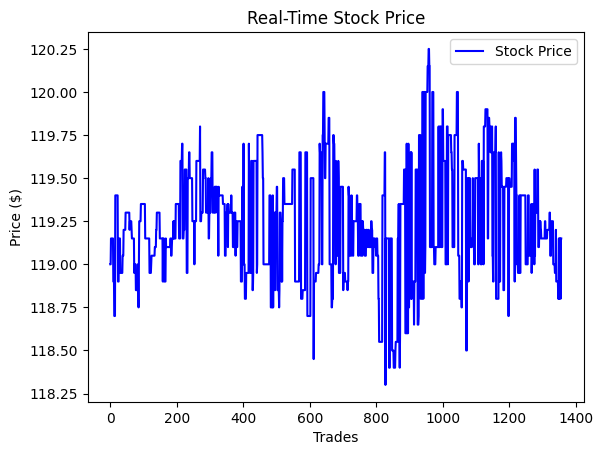

,BID,BID_Quantity,ASK_Quantity,ASK
0,119.15,528.0,109,118.80
1,119.10,2870.0,34,118.90
2,119.05,2558.0,268,118.95
3,119.00,2256.0,146,119.00
4,118.95,2636.0,460,119.05
5,118.90,2037.0,294,119.10
6,118.85,1227.0,2826,119.20
7,118.80,1130.0,2091,119.25
8,118.75,1628.0,2129,119.30
9,118.70,756.0,4681,119.35


,PRICE,VOLUME
0,118.25,89
1,118.30,364
2,118.40,637
3,118.45,393
4,118.50,600
5,118.55,267
6,118.60,540
7,118.65,888
8,118.70,1182
9,118.75,1589


In [ ]:
import random
import heapq
import time
import uuid
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import pandas as pd

# Data structures
BUY = {}  # This will hold all the buy orders (dict of price -> {id: quantity, total_quantity})
SELL = {}  # This will hold all the sell orders
BID = []  # Max heap for Bids (Buy orders)
ASK = []  # Min heap for Ask (Sell orders)
Orders = {}  # For tracking existing orders in the order book
Volume = {}  # Track volume traded for each price point

# Global variables - To update values check def start function
current_price = 50
spread = 0.20
trades = 700
sentiment = .54
shares_limit = 300

# Initialize the plot to display
fig, ax = plt.subplots()
x, y = [], []

# Functions to initialize global variables
def start():
    global current_price, spread, trades, sentiment, shares_limit
    current_price = 119
    spread = 0.25 # Multiples of .05 and should be [.05, 1.00]
    trades = 2500 
    sentiment = .44 # Advisable [.42, .56]
    shares_limit = 300 # MAximum allowed quantity to buy/sell

def share_current_price():
    print("Current Price :",current_price)

def add_order(order_id, price, quantity, order_type):
    global current_price
    if order_type == "BUY":
        if price in BUY:
            BUY[price][0][order_id] = quantity
            BUY[price][1] += quantity
        else:
            BUY[price] = [{order_id: quantity}, quantity]
            heapq.heappush(BID, -price)  # Negate to simulate max-heap behavior
    else:
        if price in SELL:
            SELL[price][0][order_id] = quantity
            SELL[price][1] += quantity
        else:
            SELL[price] = [{order_id: quantity}, quantity]
            heapq.heappush(ASK, price)
    Orders[order_id] = 1

def cancel_order(order_id, price, quantity, order_type):
    if order_type == "BUY":
        BUY[price][1] -= BUY[price][0][order_id]
        del BUY[price][0][order_id]
    else:
        SELL[price][1] -= SELL[price][0][order_id]
        del SELL[price][0][order_id]
    del Orders[order_id]

def update_order(order_id, old_price, old_quantity, old_type, new_price, new_quantity, new_type):
    if order_id in Orders:
        cancel_order(order_id, old_price, old_quantity, old_type)
        add_order(order_id, new_price, new_quantity, new_type)
    else:
        print("Cannot process the updates as order does not exist in order book - either executed or cancelled")

def execute_market_order(order_id, quantity, position):
    global current_price
    if position == "BUY":
        while ASK and quantity > 0:
            ask = ASK[0]
            
            # Check if the price exists in the SELL orders
            if ask in SELL:
                for order, qty in list(SELL[ask][0].items()):
                    if qty <= quantity:
                        quantity -= qty
                        SELL[ask][1] -= qty
                        SELL[ask][0][order] = 0
                        del SELL[ask][0][order]
                        if ask in Volume:
                            Volume[ask] += qty
                        else:
                            Volume[ask] = qty
                        print(f"{qty} shares traded for {ask}")
                        if order in Orders:
                            del Orders[order]
                    else:
                        SELL[ask][0][order] -= quantity
                        SELL[ask][1] -= quantity
                        if ask in Volume:
                            Volume[ask] += quantity
                        else:
                            Volume[ask] = quantity
                        print(f"{quantity} shares traded for {ask}")
                        quantity = 0
                    if quantity == 0:
                        break
                
                # If there is no remaining quantity, remove this ask from the ASK queue
                if quantity > 0 or (quantity == 0 and SELL[ask][1] == 0):
                    heapq.heappop(ASK)
                    del SELL[ask]
                
                current_price = ask
                share_current_price()
            else:
                print(f"Ask price {ask} does not exist in SELL orders.")
                break

        if quantity > 0:
            print(f"Cancelling the remaining shares {quantity} in the order")
    else:
        while BID and quantity > 0:
            bid = -BID[0]  # Negate to get the max bid
            
            # Check if the price exists in the BUY orders
            if bid in BUY:
                for order, qty in list(BUY[bid][0].items()):
                    if qty <= quantity:
                        quantity -= qty
                        BUY[bid][1] -= qty
                        BUY[bid][0][order] = 0
                        del BUY[bid][0][order]
                        if bid in Volume:
                            Volume[bid] += qty
                        else:
                            Volume[bid] = qty
                        print(f"{qty} shares traded for {bid}")
                        if order in Orders:
                            del Orders[order]
                    else:
                        BUY[bid][0][order] -= quantity
                        BUY[bid][1] -= quantity
                        if bid in Volume:
                            Volume[bid] += quantity
                        else:
                            Volume[bid] = quantity
                        print(f"{quantity} shares traded for {bid}")
                        quantity = 0
                    if quantity == 0:
                        break
                
                # If there is no remaining quantity, remove this bid from the BID queue
                if quantity > 0 or (quantity == 0 and BUY[bid][1] == 0):
                    heapq.heappop(BID)
                    del BUY[bid]
                
                current_price = bid
                share_current_price()
            else:
                print(f"Bid price {bid} does not exist in BUY orders.")
                break

        if quantity > 0:
            print(f"Cancelling the remaining shares {quantity} in the order")

def execute_limit_order(order_id, price, quantity, position):
    global current_price
    if position == "BUY":
        # Round the price to nearest multiple of .05
        price = round(price / 0.05) * 0.05
        price = round(price, 2)  # Ensure price has only 2 decimal places

        if price > current_price + spread:
            print("Error: For BUY limit orders price should be lower than or equal to current price + spread of the share")
        else:
            if ASK and ASK[0] == price:
                ask = ASK[0]

                if ask in SELL:
                    for order, qty in list(SELL[ask][0].items()):
                        if qty <= quantity:
                            quantity -= qty
                            SELL[ask][0][order] = 0
                            del SELL[ask][0][order]
                            SELL[ask][1] -= qty
                            if ask in Volume:
                                Volume[ask] += qty
                            else:
                                Volume[ask] = qty
                            print(f"{qty} shares traded for {ask}")
                            if order in Orders:
                                del Orders[order]
                        else:
                            SELL[ask][0][order] -= quantity
                            SELL[ask][1] -= quantity
                            if ask in Volume:
                                Volume[ask] += quantity
                            else:
                                Volume[ask] = quantity
                            print(f"{quantity} shares traded for {ask}")
                            quantity = 0
                        if quantity == 0:
                            break
                    
                    if quantity > 0 or (quantity == 0 and SELL[ask][1] == 0):
                        heapq.heappop(ASK)
                        del SELL[ask]
                    
                    current_price = ask
                    share_current_price()
                else:
                    print(f"Ask price {ask} does not exist in SELL orders.")
                    return
            else:
                print(f"Adding {quantity} in order book at price {price}")
                add_order(order_id, price, quantity, position)

    else:  # SELL
        price = round(price / 0.05) * 0.05  # Round to nearest multiple of .05
        price = round(price, 2)  # Ensure price has only 2 decimal places

        if price < current_price - spread:
            print("Error: For SELL limit orders price should be greater than or equal to current price - spread of the share")
        else:
            if BID and -BID[0] == price:
                bid = -BID[0]

                if bid in BUY:
                    for order, qty in list(BUY[bid][0].items()):
                        if qty <= quantity:
                            quantity -= qty
                            BUY[bid][1] -= qty
                            BUY[bid][0][order] = 0
                            del BUY[bid][0][order]
                            if bid in Volume:
                                Volume[bid] += qty
                            else:
                                Volume[bid] = qty
                            print(f"{qty} shares traded for {bid}")
                            if order in Orders:
                                del Orders[order]
                        else:
                            BUY[bid][0][order] -= quantity
                            BUY[bid][1] -= quantity
                            if bid in Volume:
                                Volume[bid] += quantity
                            else:
                                Volume[bid] = quantity
                            print(f"{quantity} shares traded for {bid}")
                            quantity = 0
                        if quantity == 0:
                            break
                    
                    if quantity > 0 or (quantity == 0 and BUY[bid][1] == 0):
                        heapq.heappop(BID)
                        del BUY[bid]
                    
                    current_price = bid

                    share_current_price()
                else:
                    print(f"Bid price {bid} does not exist in BUY orders.")
                    return
            else:
                print(f"Adding {quantity} in order book at price {price}")
                add_order(order_id, price, quantity, position)

def get_order_type():
    return "LIMIT" if random.random() < 0.65 else "MARKET"

def get_order_position():
    return "BUY" if random.random() <= sentiment else "SELL"

def generate_id():
    return str(uuid.uuid4())  # Generates a unique ID

def random_quantity():
    return random.randint(1, shares_limit)

def random_price(base_price):
    #step = random.choice([-2, -1, 1, 2]) * 0.05  # Random step for the price
    step = random.choice([x for x in range(-int(spread/.05), int(spread/.05) + 1) if x != 0]) * .05
    price = base_price + step
    rounded_price = round(price / 0.05) * 0.05  # Round to nearest multiple of 0.05
    return round(rounded_price, 2)  # Ensure the result is rounded to 2 decimal places

def generate_random_order():
    order_id = generate_id()
    position = get_order_position()
    order_type = get_order_type()
    quantity = random_quantity()
    price = random_price(current_price)

    if order_type == "MARKET":
        print(f"{order_id} {quantity} {current_price} {position} {order_type}")
        execute_market_order(order_id, quantity, position)
    else:
        print(f"{order_id} {quantity} {price} {position} {order_type}")
        execute_limit_order(order_id, price, quantity, position)

# Function to update plot
def update_price(new_x, new_y):
    x.append(new_x)
    y.append(new_y)
    ax.clear()
    ax.plot(x, y, label="Stock Price", color='blue')
    ax.set_title("Real-Time Stock Price")
    ax.set_xlabel("Trades")
    ax.set_ylabel("Price ($)")
    ax.legend()
    ax.autoscale_view()  # Autoscale

    display(fig)  # Display the updated figure
    # plt.pause(0.1)  # Pause to make sure plot updates smoothly

def update_order_book():
    bid = list(BUY.keys())
    bid.sort(reverse=True)
    ask = list(SELL.keys())
    ask.sort()
    order_book = { # pd.Series used, to allow columns to be of unequal lengths
        "BID": pd.Series(bid),
        "BID_Quantity": pd.Series([int(BUY[key][1]) for key in bid]),
        "ASK_Quantity": pd.Series([int(SELL[key][1]) for key in ask]),
        "ASK": pd.Series(ask)
    }
    order_book_frame = pd.DataFrame(order_book)
    display(order_book_frame)

def update_volume():
    price_points = list(Volume.keys())
    price_points.sort()

    volume_traded = {
        "PRICE": price_points,
        "VOLUME": [Volume[key] for key in price_points]
    }
    volume_traded_frame = pd.DataFrame(volume_traded)
    display(volume_traded_frame)

# Main execution loop
def main():
    start()
    for i in range(trades):
        generate_random_order()
        clear_output(wait=True)  # Clear the previous output in the notebook
        update_price(i, current_price)
        update_order_book()
        update_volume()
        time.sleep(0.5)

plt.close(fig)

if __name__ == "__main__":
    main()
